In [13]:
# April 2025
# Data exploration and cleaning
# Violeta Berdejo-Espinola & Ákos Hájas

In [14]:
# %pip install pyarrow polars levenshtein langdetect fasttext-wheel

In [15]:
import re
import pandas as pd
import polars as pl

df_repo = pl.read_parquet("../datasets/from_repo/majom_2025_april.parquet")

df_pos = pd.read_excel("../datasets/from_translate/translatE_spanish_positives_112.xlsx")

print(len(df_repo), len(df_pos))

10340 111


# data after 2019

In [16]:
df_post_2019 = (df_repo.filter((pl.col('pub_year') == 2024) | (pl.col('pub_year') == 2023) | (pl.col('pub_year') == 2022) | (pl.col('pub_year') == 2021) | (pl.col('pub_year') == 2020)))

# df_post_2019.write_csv('../data/v2/pos_neg_2020-2024.csv')

len(df_post_2019)

1884

# rename columns, drop nas, subset dfs

In [17]:

# subset

df_repo = df_repo.select(['title', 'abstract_es', 'body_es', 'journal', 'pub_year'])
df_repo = df_repo.rename({'abstract_es': 'abstract', 
                          'body_es':'body'})


df_pos = df_pos[['Title - non-English language','Abstract - non-English','Journal','Year','Reference Type']]
df_pos =  df_pos.rename(columns={'Title - non-English language':"title",
                                 'Abstract - non-English':"abstract", 
                                 'Journal':"journal",
                                 'Year':"pub_year",
                                 'Reference Type':"ref_type"
                                 }
                        )

# fill empty strings with null, unwanted articles 

df_repo = df_repo.with_columns(
    pl.when(pl.col(pl.String).str.len_chars() == 0)
    .then(None)
    .otherwise(pl.col(pl.String))
    .name.keep()
)

# drop duplicates, nulls

df_repo = df_repo.unique(subset="title")

df_repo = df_repo.drop_nulls(subset=["title", "abstract", "journal"])

df_repo = df_repo.filter(
    ~pl.col("title").str.contains("In Memoriam|Editorial|Fe de erratas|FE DE ERRATA|ERRATA|aniversario|ARTÍCULO RETRACTADO") #|
    # ~pl.col("main_text_spa").str.contains("Texto completo disponible sólo en PDF|Full text available only in PDF format Texto completo disponible sólo en PDF")
)

df_pos = df_pos.dropna(subset=["title", "abstract","journal"])

# cast to polars

df_pos = pl.from_pandas(df_pos)

print(len(df_repo), len(df_pos))

10009 69


# normalize text


In [18]:
# function to normalize text

def normalize_title(title):
    title = re.sub("\s+", " ", title).capitalize().strip().replace(".", "")
    title = re.sub("\xa0", " ", title)
    title = re.sub("_x000d__x000d_", " ", title)
    return re.sub("\n{1,}", " ", title)

# normalize  title and journal

df_pos = df_pos.with_columns(  
    pl.col("title")
    .map_elements(normalize_title, return_dtype=pl.Utf8),

    pl.col('journal')
    .map_elements(normalize_title, return_dtype=pl.Utf8),
)

df_repo = df_repo.with_columns(
    pl.col('title')
    .map_elements(normalize_title, return_dtype=pl.Utf8),

    pl.col('journal')
    .map_elements(normalize_title, return_dtype=pl.Utf8),
)

print(len(df_repo), len(df_pos))

10009 69


# remove instances with an abstract shorter than 300 characters


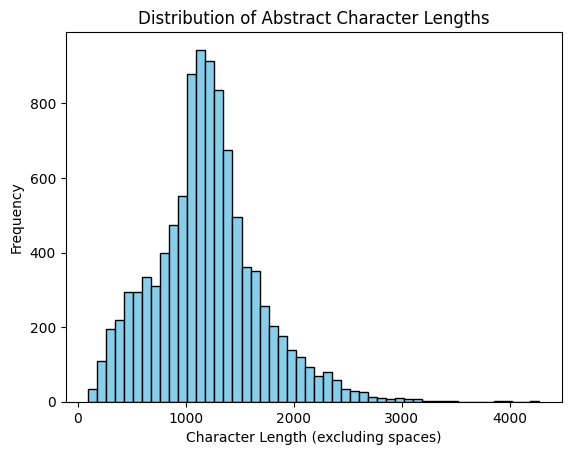

In [19]:
import matplotlib.pyplot as plt

# Calculate character lengths excluding spaces
char_lens = [len(abstract.replace(" ", "")) for abstract in df_repo['abstract']]

# Plot the histogram
plt.hist(char_lens, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Character Length (excluding spaces)')
plt.ylabel('Frequency')
plt.title('Distribution of Abstract Character Lengths')
plt.show()

In [20]:
# remove instances with an abstract shorter than 300 characters

df_repo = df_repo.with_columns(
    pl.col("abstract")
    .str.len_chars()
    .alias("abstract_length")
)

df_repo = df_repo.filter(
    pl.col("abstract_length") >= 300
)

print(len(df_repo), len(df_pos))

9884 69


# format repo titles in english

In [21]:
# re-label titles in english but text in spanish
title_in_eng = 'Effects of cattle exclusion on the vegetation at a pink-footed shearwater (ardenna creatopus) colony on robinson crusoe island, chile'
title_in_spa = normalize_title('EFECTOS DE LA EXCLUSIÓN DE GANADO VACUNO SOBRE LA VEGETACIÓN EN EL ÁREA OCUPADA POR UNA COLONIA DE FARDELA BLANCA (Ardenna creatopus) EN LA ISLA ROBINSON CRUSOE, CHILE')

df_repo = df_repo.with_columns(
    pl.when(pl.col('title') == title_in_eng)
    .then(pl.lit(title_in_spa)) # pl.lit tells polars "this is a literal string", not a column name.
    .otherwise(pl.col('title'))
    .alias('title')
)

print(len(df_repo), len(df_pos))

9884 69


# remove non-spanish titles in repo


In [22]:
from fasttext.FastText import _FastText

model_path = 'lid.176.ftz'
model = _FastText(model_path=model_path)

# function to detect languages

def get_lang(text: str) -> str:
    lang, _ = model.predict(text)
    lang = lang[0].removeprefix('__label__')
    # conf = conf[0]

    return lang

# detect languages

df_repo_all_lang = df_repo.with_columns(
    pl.col("title")
    .map_elements(get_lang, return_dtype=pl.Utf8)
    .alias("language")
)

# filter spanish only

df_repo = df_repo_all_lang.filter(
    pl.col('language') == 'es'
)

print(f'articles in all languages: {len(df_repo_all_lang)}\narticles in spanish: {len(df_repo)}')

# function to find exceptions in detection
# def safe_detect(text):
#     try:
#         return get_lang(text)
#     except Exception:
#         print("This row throws an error:", text)
#         return "error"

articles in all languages: 9884
articles in spanish: 6851


# remove titles in pos with text in english


In [23]:
text_in_english = 'La liebre amenazada lepus flavigularis prefiere establecer sus sitios de alimentación y descanso en potreros con presencia de ganado'

df_pos = df_pos.filter(
    ~(pl.col("title") == text_in_english)
)

len(df_repo), len(df_pos)

(6851, 68)

# remove unwanted publication years

In [24]:
# remove years not screened in amano 2021

# define the journal-to-year mapping

journal_years = {
    'Acta zoológica mexicana': [1984,1985,1986,1987,1988,1989,
                                1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
                                2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
                                2010,2011,2012,2013,2014,2015,2016,2017,2018,2019],
    
    # 'Ardeola': [1954,1955,1956,1957,1958,1959,
    #             1960,1961,1962,1963,1964,1965,1966,1967,1968,1969,
    #             1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,
    #             1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,
    #             1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
    #             2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
    #             2010,2011,2012,2013,2014,2015,2016,2017,2018,2019],
    
    # 'Bioscriba': [2008,2009,
    #               2010,2011,2012,2013,2014,2015,2016,2017],
    
    'Ecologia austral': [2002,2003,2004,2005,2006,2007,2008,2009,
                          2010,2011,2012,2013,2014,2015,2016,2017,2018],
    
    'Ecología austral': [2001,2002,2003,2004,2005,2006,2007,2008,2009,
                         2010,2011,2012,2013,2014,2015,2016,2017,2018,2019],
    
    'Ecología aplicada': [2002,2003,2004,2005,2006,2007,2008,2009,
                          2010,2011,2012,2013,2014,2015,2016,2017,2018],
    
    'Galemys': [1997,1998,1999,
                2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
                2010,2011,2012,2013,2014,2015,2016,2017],
    
    'Huitzil': [2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
                2010,2011,2012,2013,2014,2015,2016,2017,2018,2019],
    
    'Barbastella': [2012,2013,2014,2015,2016,2017,2018,2019],   # text mainly in english
    
    'Madera y bosques': [2005,2006,2007,2008,2009,
                         2010,2011,2012,2013,2014,2015,2016,2017,2018,2019],
    
    'Mastozoología neotropical': [1994,1995,1996,1997,1998,1999,
                                  2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
                                  2010,2011,2012,2013,2014,2015,2016,2017,2018],
    
    'Quebracho': [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018],
    
    'Quebracho (santiago del estero)': [2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018],
    
    'Revista chilena de historia natural': [1987,1988,1989,
                                     1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
                                     2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
                                     2010,2011,2012,2013,2014,2015,2016,2017,2018,2019],
    
    'Revista de biología tropical': [1989,
                                     1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,
                                     2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,
                                     2010,2011,2012,2013,2014,2015,2016,2017,2018,2019],
    
    'Revista mexicana de biodiversidad': [2005,2006,2007,2008,2009,2010,
                                          2011,2012,2013,2014,2015,2016,2017,2018,2019],
    
    'Revista mexicana de ciencias forestales': [2011,2012,2013,2014,2015,2016,2017,2018],
    
    'Therya': [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
}

# convert to df

journal_years =  pl.DataFrame(data = {
    "journal": journal_years.keys(),
    "pub_year": journal_years.values()
    })

journal_years = journal_years.explode("pub_year")

# apply the filter dynamically

df_pos = df_pos.join(journal_years, on=["pub_year", "journal"], how='semi')

df_repo_filtered = df_repo.join(journal_years, on=["pub_year", "journal"], how='semi')

print(len(df_repo_filtered), len(df_pos))

filtered_df_repo = df_repo.filter(
    ~pl.col('title')
    .is_in(df_repo_filtered
           .select('title')
           .to_series())
)

print(filtered_df_repo)

5552 49
shape: (1_299, 7)
┌───────────────┬───────────────┬──────────────┬──────────────┬──────────┬──────────────┬──────────┐
│ title         ┆ abstract      ┆ body         ┆ journal      ┆ pub_year ┆ abstract_len ┆ language │
│ ---           ┆ ---           ┆ ---          ┆ ---          ┆ ---      ┆ gth          ┆ ---      │
│ str           ┆ str           ┆ str          ┆ str          ┆ i64      ┆ ---          ┆ str      │
│               ┆               ┆              ┆              ┆          ┆ u32          ┆          │
╞═══════════════╪═══════════════╪══════════════╪══════════════╪══════════╪══════════════╪══════════╡
│ Potencial de  ┆ Resumen En    ┆ En México,   ┆ Revista      ┆ 2019     ┆ 1575         ┆ es       │
│ reforestación ┆ México, los   ┆ los bosques  ┆ mexicana de  ┆          ┆              ┆          │
│ de …          ┆ bosques…      ┆ templad…     ┆ ciencias f…  ┆          ┆              ┆          │
│ Una nueva     ┆ Resumen El    ┆ Hasta la     ┆ Revista de   ┆ 2

In [25]:
# check number of of journals in each df

import numpy as np 

print(len(df_repo['journal'].unique()))
print(len(df_pos['journal'].unique()))

# check journals in repo
# sorted(list(df_repo['journal'].unique()))

# check journal name differences 

not_in_repo = df_pos.filter(
    ~pl.col('journal')
    .is_in(df_repo
           .select('journal')
           .to_series())
)

sorted(list(not_in_repo['journal']))

27
14


['Ecologia austral']

# similarity between repo and pos titles

In [26]:
from Levenshtein import ratio

repo_title = df_repo_filtered["title"]
pos_title = df_pos["title"]
print(len(repo_title), len(pos_title))

# batch positive titles to reduce memory workload

BATCH_SIZE = 100

for i in range(0, len(pos_title), BATCH_SIZE):
    collect_similarity = {}

    # check similarity
    for title in pos_title[i:i+BATCH_SIZE]:
        collect_similarity[title] = [
            i for i, rt in enumerate(repo_title) 
            if ratio(title, rt) > 0.95
            ]
            
    # save as df
    df_ratio = pl.DataFrame({
        'title': list(collect_similarity.keys()), 
        'similarity': list(collect_similarity.values())
        })
    
# get the lenght of similarity lists

df_ratio = df_ratio.with_columns(similar_instances=pl.col("similarity").list.len())
print(df_ratio['similar_instances'].value_counts())

# flatten similarity list

df_ratio = df_ratio.explode('similarity')

5552 49
shape: (3, 2)
┌───────────────────┬───────┐
│ similar_instances ┆ count │
│ ---               ┆ ---   │
│ u32               ┆ u32   │
╞═══════════════════╪═══════╡
│ 0                 ┆ 5     │
│ 1                 ┆ 39    │
│ 2                 ┆ 5     │
└───────────────────┴───────┘


In [27]:
# df_pos.filter(pl.col('journal')=="Galemys")

In [28]:
# find similar instances across dfs

similarity_data_list = []

# loop through df_ratio 
for row_master in df_ratio.rows(named=True):
    similarity_master = row_master['similarity']
    title_master = row_master['title']
    
    print(similarity_master)

    # loop through repo titles with index
    for i, row_repo in enumerate(df_repo_filtered['title']):
        
        if i == similarity_master:
            print(f"Match found: {row_repo}")
            df_repo_filtered.with_columns(pos_similarity=similarity_master)
            
            similarity_data = {
                'position_in_repo':i,
                'similarity':similarity_master,
                'name_in_repo':row_repo,
                'name_in_pos':title_master
            }
            
            similarity_data_list.append(similarity_data)

# create dataframe
similarity_data_df = pl.DataFrame(similarity_data_list)
len(similarity_data_df)

4357
Match found: Recuperación de la colonia de miniopterus schreibersii de la cueva de cueva de ágreda (soria)
4976
Match found: Recuperación de la colonia de miniopterus schreibersii de la cueva de cueva de ágreda (soria)
1937
Match found: Ocupación de cajas-refugio por murciélagos en navarra
3371
Match found: Pasos agrícolas inferiores de carreteras: su importancia para los murciélagos como refugio y lugar para cruzar la vía
415
Match found: Conservación de colonias reproductoras de murciélagos cavernícolas mediante refugios artificiales
1133
Match found: Supervivencia de guanacos (lama guanicoe) reintroducidos con y sin período de preadapatación en el parque nacional quebrada del condorito, córdoba, argentina
3774
Match found: El uso de los parques urbanos con vegetación por murciélagos insectívoros en san josé, costa rica
4123
Match found: Erradicación de especies invasoras: ciencia, actitud y entendimiento el castor en tierra del fuego
5294
Match found: Abundancia poblacional y m

49

In [29]:
# get unique names

# save duplicated titles in df 

matches_duplicates = similarity_data_df.filter(
    pl.col("name_in_repo").is_in(
        similarity_data_df.select("name_in_repo")
          .group_by("name_in_repo")
          .agg(pl.count().alias("count"))
          .filter(pl.col("count") > 1)
          .get_column("name_in_repo")
    )
)

print(matches_duplicates)

# remove duplicates

similarity_data_df = similarity_data_df.unique(subset="name_in_repo")
len(similarity_data_df)

shape: (4, 4)
┌──────────────────┬────────────┬─────────────────────────────────┬────────────────────────────────┐
│ position_in_repo ┆ similarity ┆ name_in_repo                    ┆ name_in_pos                    │
│ ---              ┆ ---        ┆ ---                             ┆ ---                            │
│ i64              ┆ i64        ┆ str                             ┆ str                            │
╞══════════════════╪════════════╪═════════════════════════════════╪════════════════════════════════╡
│ 4357             ┆ 4357       ┆ Recuperación de la colonia de … ┆ Recuperación de la colonia de  │
│                  ┆            ┆                                 ┆ …                              │
│ 4976             ┆ 4976       ┆ Recuperación de la colonia de … ┆ Recuperación de la colonia de  │
│                  ┆            ┆                                 ┆ …                              │
│ 2023             ┆ 2023       ┆ Primeros resultados sobre la a… ┆ Primeros 

/var/folders/dz/szfgpm5s0tn_frclv0gl7m2c0000gr/T/ipykernel_39157/984420911.py:9: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias("count"))


47

In [30]:
# documents in pos but not in repo

filtered_df = df_pos.filter(
    ~pl.col('title')
    .is_in(similarity_data_df
           .select('name_in_pos')
           .to_series())
)
print(len(filtered_df['title']))
sorted(list(filtered_df['title']))

# please read -> all these titles have the main text in English

# in English: Almacenamiento en frío del esperma de la trucha endémica Oncorhynchus mykiss nelsoni: una estrategia para la conservación a corto plazo del germoplasma de especies endémicas
# in English: Germinación de tres especies de Fabaceae de interés para la restauración ecológica en el Monte Austral, Patagonia, Argentina.
# in English: Incubación Artificial de huevo del Pavón Cornudo  Oreophasis derbianus (Aves: Cracidae) 
# in English: Murciélagos (Mammalia: Chiroptera) en áreas naturales y reforestadas en Rancho Alegre, Paraná, Brasil
# in English: Éxito o fracaso: el papel de la restauración ecológica en la recuperación de la diversidad y la función de los escarabajos del estiércol en una selva tropical

5


['Almacenamiento en frío del esperma de la trucha endémica oncorhynchus mykiss nelsoni: una estrategia para la conservación a corto plazo del germoplasma de especies endémicas',
 'Germinación de tres especies de fabaceae de interés para la restauración ecológica en el monte austral, patagonia, argentina',
 'Incubación artificial de huevo del pavón cornudo oreophasis derbianus (aves: cracidae)',
 'Murciélagos (mammalia: chiroptera) en áreas naturales y reforestadas en rancho alegre, paraná, brasil',
 'Éxito o fracaso: el papel de la restauración ecológica en la recuperación de la diversidad y la función de los escarabajos del estiércol en una selva tropical']

# join and label data

In [32]:
# subset positive instances in repo

pos = similarity_data_df.unique(subset="name_in_pos")

# only include pos instances that are in repo
# then label instances

df_master = df_repo_filtered.with_columns(
    pl.when(
        pl.col("title").is_in(pos["name_in_repo"])
    )
    .then(1)
    .otherwise(0)
    .alias("label")
)

# drop duplicates, nulls

df_master = df_master.unique(subset="title")
print(len(df_master))

df_master = df_master.drop_nulls(subset=["abstract","title","journal"])

print(len(df_master))
print(df_master["label"].value_counts())
df_master

5550
5550
shape: (2, 2)
┌───────┬───────┐
│ label ┆ count │
│ ---   ┆ ---   │
│ i32   ┆ u32   │
╞═══════╪═══════╡
│ 1     ┆ 44    │
│ 0     ┆ 5506  │
└───────┴───────┘


title,abstract,body,journal,pub_year,abstract_length,language,label
str,str,str,str,i64,u32,str,i32
"""Dendrocronopirología: análisis…","""El régimen de incendios es una…","""nota de investigación dendroc…","""Revista mexicana de ciencias f…",2014,1326,"""es""",0
"""Estudio de flujos verticales d…","""En este estudio se utilizaron …","""giovanni daneri centro de cien…","""Revista chilena de historia na…",2001,1349,"""es""",0
"""Diagnosis prospectiva sobre la…","""Recientemente, la laguna Bacal…","""ecología diagnosis prospectiv…","""Revista mexicana de biodiversi…",2013,1449,"""es""",0
"""Análisis de subpoblaciones cin…","""Resumen La valoración subjetiv…","""Semen analysis is usually the …","""Revista de biología tropical""",2019,1527,"""es""",0
"""Caracterización ecohidrológica…","""Los Humedales Alto Andinos (HA…","""introducción. los humedales al…","""Ecología aplicada""",2015,2238,"""es""",0
…,…,…,…,…,…,…,…
"""Albinismo platinado en liomys …","""El albinismo es una anormalida…","""artículos albinismo platinado…","""Therya""",2013,361,"""es""",0
"""Biología reproductiva de aniso…","""Anisotremus interruptus es una…","""Los peces de la familia Haemul…","""Revista de biología tropical""",2012,1418,"""es""",0
"""Reconstrucción de algunas sequ…","""Resumen: El impacto histórico …","""Conocer la dinámica climatológ…","""Revista mexicana de ciencias f…",2018,1603,"""es""",0


In [ ]:
# save to disk 

# df_master.write_csv('../data/v2/pos_neg.csv')

In [ ]:
# df_master.filter(pl.col('journal')=="Galemys").group_by('label').agg(pl.count())
# galemys = df_master.filter(pl.col("journal")=='Galemys')
# galemys

# galemys.write_csv('../data/v2/galemys.csv')